# Notebook for VV Polarization Studies at Parton Level (LHE input format)

In [1]:
#from ROOT import TFile, gROOT, TH1D, TLegend, THStack , TChain, TLorentzVector, gDirectory
#from tools import *
import math
import os
import time
import collections
import itertools
import matplotlib.pyplot as plt

import numpy as np
import mplhep as hep
import awkward as ak
import vector
vector.register_awkward()
import hist
import pylhe

# CMS experiment styles
hep.style.use("CMS") 


In [2]:
## PyLHE Event format

## Read Events from Parquet into AWKWARD array format

In [3]:
files_list = [ 
               "/Users/sznajder/WorkM1/workdir/Notebooks/VBS_Charlot/EWK_ZZjj_LL_14_TeV.parquet",
               "/Users/sznajder/WorkM1/workdir/Notebooks/VBS_Charlot/EWK_ZZjj_LT_14_TeV.parquet",
               "/Users/sznajder/WorkM1/workdir/Notebooks/VBS_Charlot/EWK_ZZjj_TT_14_TeV.parquet"
             ]
pols = ["LL","LT","TT"]
samples = { pol : ak.from_parquet(file) for pol,file in zip(pols,files_list) }
samples

{'LL': <EventArray [{eventinfo: {...}, ...}, ..., {...}] type='227731 * Event[even...'>,
 'LT': <EventArray [{eventinfo: {...}, ...}, ..., {...}] type='188690 * Event[even...'>,
 'TT': <EventArray [{eventinfo: {...}, ...}, ..., {...}] type='200000 * Event[even...'>}

## Convert from AWKARD ARRAYS to PANDAS DATAFRAME and vice versa

In [4]:
# Convert from Awkward to Pandas
#df_events = ak.topandas(events, flatten=True)
#df_events = ak.to_dataframe(events)
#print(type(df_awk))

# Convert from Pandas to Awkward 
#af = awkward.fromiter(df)
#print(af)

## Loop over events to fill histos

In [10]:
# Define lepton , jets and vector boson containers
lep_collection = []
jet_collection = []
vbo_collection = []

start = time.time()

pols = ["LL"]
histos ={}
for pol in pols:
    
    # Define histos
    histos.update({
                "hist_m4l_{}".format(pol) :  hist.Hist.new.Reg(150, 0, 150).Int64() ,

                "hist_lep_pt_{}".format(pol) :  hist.Hist.new.Reg(150, 0, 150).Int64() ,
                "hist_lep_eta_{}".format(pol) : hist.Hist.new.Reg(50, -5,   5).Int64() ,
                "hist_lep_mll_{}".format(pol) : hist.Hist.new.Reg(150, 0, 500).Int64() ,
                "hist_lep_m4l_{}".format(pol) : hist.Hist.new.Reg(150, 0, 500).Int64() ,

                "hist_jet_pt_{}".format(pol) :  hist.Hist.new.Reg(150, 0, 150).Int64() ,
                "hist_jet_eta_{}".format(pol) : hist.Hist.new.Reg(50, -5,   5).Int64() ,
                "hist_jet_deta_{}".format(pol) : hist.Hist.new.Reg(150,-5,  5).Int64() ,
                "hist_jet_mjj_{}".format(pol) : hist.Hist.new.Reg(150,0, 5000).Int64() ,

                "hist_Z_pt_{}".format(pol) :  hist.Hist.new.Reg(150, 0, 150).Int64() ,
                "hist_Z_eta_{}".format(pol) : hist.Hist.new.Reg(50, -5, +5).Int64() ,
                "hist_Z_m_{}".format(pol) : hist.Hist.new.Reg(150,  0, 500).Int64()
              })
    
    
    # Get the events AWK array
    events = samples[pol]
    
    # Define a selections 
    muons     = events.particles[ ( np.abs(events.particles.id) == 13 ) ] # filter mu+ or mu-
    electrons = events.particles[ ( np.abs(events.particles.id) == 11 ) ] # filter el+ or el-
    leptons   = events.particles[ ( np.abs(events.particles.id) == 13 ) | 
                                  ( np.abs(events.particles.id) == 11 )  ]    
    partons   = events.particles[ ( 0 < ( np.abs(events.particles.id) < 7 ) | 
                                   ( np.abs(events.particles.id) == 21 )) &
                                  ( events.particles.status == 1 ) ]    

    # Get 4-momenta of Z's and 4 leptons
    p4l = leptons.vector 
    p4mu = muons[ (ak.num(muons) == 4) & (ak.sum(muons.id, axis=-1) == 0)].vector
    p4el = electrons[ (ak.num(electrons) == 4) & (ak.sum(electrons.id, axis=-1) == 0)].vector
    p2mu = muons[ (ak.num(muons) == 2) & (ak.sum(muons.id, axis=-1) == 0)].vector
    p2el = electrons[ (ak.num(electrons) == 2) & (ak.sum(electrons.id, axis=-1) == 0)].vector
    m4l = (p4l[:,0]+p4l[:,1]+p4l[:,2]+p4l[:,3]).m 
    p2l = ak.concatenate( [(p2mu[:,0]+p2mu[:,1]) , (p2el[:,0]+p2el[:,1])] )
    ptll = p2l.pt
    etall = p2l.eta
    mll = p2l.m
    
    p2j = partons.vector
    mjj = (p2j[:,0]+p2j[:,1]).m
    ptjj = (p2j[:,0]+p2j[:,1]).pt
    etajj = (p2j[:,0]+p2j[:,1]).eta
    detajj = np.abs(partons.vector.eta[:,1]-partons.vector.eta[:,0])
    jpt = ak.flatten(p2j.pt)
    jeta = ak.flatten(p2j.eta)
    
    
    # Fill histos    
    
    histos["hist_lep_pt_{}".format(pol)].fill(ak.flatten(p4l.pt))
    histos["hist_lep_eta_{}".format(pol)].fill(ak.flatten(p4l.eta)) 
    histos["hist_lep_mll_{}".format(pol)].fill(p2l.m)
    histos["hist_lep_m4l_{}".format(pol)].fill(ak.flatten(p4l.m)) 
    
    histos["hist_jet_pt_{}".format(pol)].fill(ak.flatten(p2j.pt)) 
    histos["hist_jet_eta_{}".format(pol)].fill(ak.flatten(p2j.eta))
    histos["hist_jet_deta_{}".format(pol)].fill(detajj) 
    histos["hist_jet_mjj_{}".format(pol)].fill(mjj) 
    
    histos["hist_Z_pt_{}".format(pol)].fill(ptll) 
    histos["hist_Z_eta_{}".format(pol)].fill(etall)
    histos["hist_Z_m_{}".format(pol)].fill(mll) 
    
    
    '''
    # Filter minimum DeltaR between partons
    metric = np.sum(partons[:,0].deltaR2(partons[:,1]), axis=-1)
    i_best = ak.argmin(metric, keepdims=True, axis=-1)
    best = partons[i_best]
    '''
    
    '''
    # Define a selection using a mask to keep the AWK array sizes
    mu_p_masked = events.particles.mask[events.particles.id == 13 ]
    mu_n_masked = events.particles.mask[events.particles.id == -13 ]
    el_p_masked = events.particles.mask[events.particles.id == 11 ]
    el_n_masked = events.particles.mask[events.particles.id == -11 ]
    '''
    
    '''
    # Combine leptons into pairs that comes from Z decays and get Z 4-momentum                             
    mu_p, mu_n = ak.unzip( ak.combinations([muons_p, muons_n],2) )
    el_p, el_n = ak.unzip( ak.combinations([muons_p, muons_n],2) )
    pZmumu = mu_p.vector + mu_n.vector
    pZelel = mu_p.vector + mu_n.vector
    '''

print(f"Time to run: {(time.time() - start)} seconds")     

Time to run: 1.3725321292877197 seconds


## Leptons plots 

[Text(1, 0, 'mass 4l'), Text(0, 1, 'counts')]

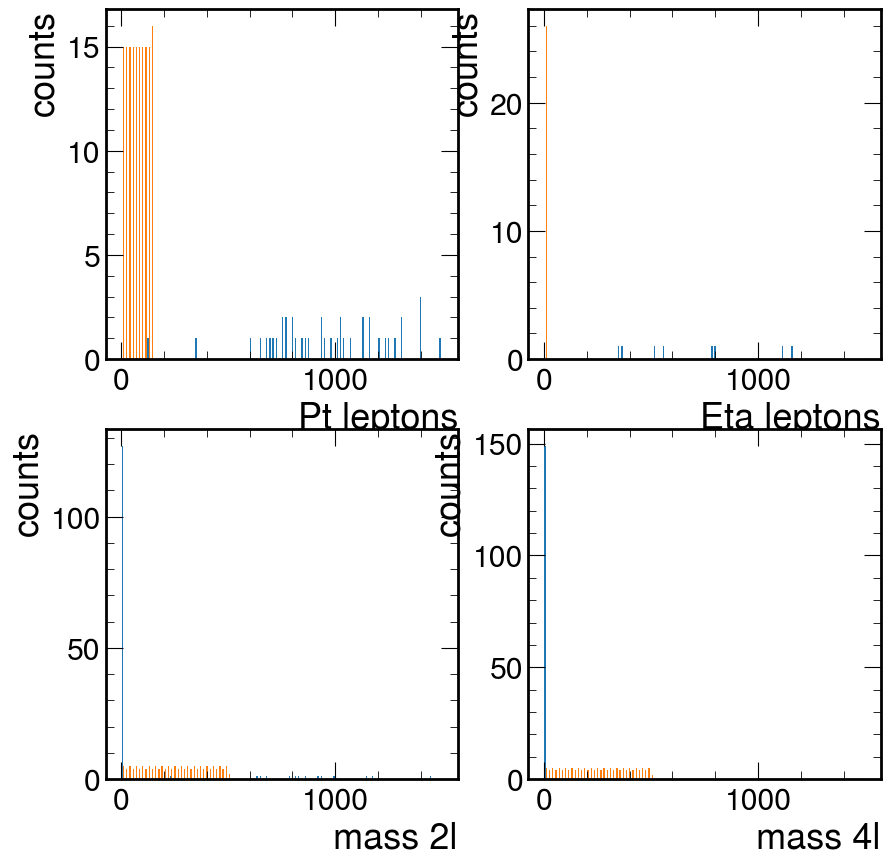

In [13]:
fig, ax = plt.subplots(2,2)
ax[0,0].hist( histos["hist_lep_pt_LL"], bins=100, range=(0, 1500) )
ax[0,0].set(xlabel='Pt leptons', ylabel='counts')
ax[0,1].hist( histos["hist_lep_eta_LL"], bins=100, range=(0, 1500) )
ax[0,1].set(xlabel='Eta leptons', ylabel='counts')
ax[1,0].hist( histos["hist_lep_mll_LL"], bins=100, range=(0,1500) )
ax[1,0].set(xlabel='mass 2l', ylabel='counts')
ax[1,1].hist( histos["hist_lep_m4l_LL"], bins=100, range=(0, 1500) )
ax[1,1].set(xlabel='mass 4l', ylabel='counts')

## Jets plots

In [ ]:
fig, ax = plt.subplots(2,2)
ax[0,0].hist(jpt, bins=100, range=(0, 1500) )
ax[0,0].set(xlabel='Jet Pt', ylabel='counts')
ax[0,1].hist(jeta, bins=100, range=(-6, 6) )
ax[0,1].set(xlabel='Jet eta', ylabel='counts')
ax[1,0].hist( mjj, bins=100, range=(0,5000) )
ax[1,0].set(xlabel='M_jj', ylabel='counts')
ax[1,1].hist( detajj, bins=100, range=(0,10) )
ax[1,1].set(xlabel='DEta_jj', ylabel='counts')
